In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [484]:
database = pd.read_csv("./data/total_2000.csv")
print(database.shape)
database.head()

(151671, 9)


,Year,Surname,Count,PCT2PRACE,PCTAIAN,PCTAPI,PCTBLACK,PCTHISPANIC,PCTWHITE
0,2000,SMITH,2376206,1.63,0.85,0.40,22.22,1.56,73.35
1,2000,JOHNSON,1857160,1.82,0.91,0.42,33.80,1.50,61.55
2,2000,WILLIAMS,1534042,2.01,0.78,0.37,46.72,1.60,48.52
3,2000,BROWN,1380145,1.86,0.83,0.41,34.54,1.64,60.71
4,2000,JONES,1362755,1.85,0.94,0.35,37.73,1.44,57.69


In [453]:
faculties = pd.read_csv("./data/faculties_with_gender.csv")[["Id", "LastName"]]
faculties = faculties.drop_duplicates()
print(faculties.shape)
faculties.head()

(692, 2)


,Id,LastName
0,1485,BALAKRISHNAN
1,2030,BARRETT
2,2190,BELOBABA
3,2695,BINZEL
4,4030,CAHOY


In [454]:
faculties['Contain'] = faculties.LastName.apply(lambda x: database['Surname'].eq(x).any())
faculties[['Contain']] = faculties['Contain'].astype(str)
faculties.head()

,Id,LastName,Contain
0,1485,BALAKRISHNAN,True
1,2030,BARRETT,True
2,2190,BELOBABA,False
3,2695,BINZEL,False
4,4030,CAHOY,True


Name included: 506, Name not included: 186


([<matplotlib.patches.Wedge at 0x7fe9fba1ce80>,
 [Text(-0.7305843398251542, 0.8223420957255222, 'Name included'),
  Text(0.7305843398251541, -0.8223420957255222, 'Name not included')],
 [Text(-0.3985005489955386, 0.448550234032103, '73.1%'),
  Text(0.39850054899553855, -0.448550234032103, '26.9%')])

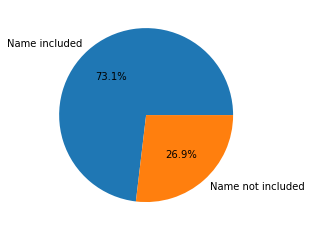

In [455]:
contain_count = faculties["Contain"].value_counts()["True"]
not_contain_count = faculties["Contain"].value_counts()["False"]
print("Name included: %d, Name not included: %d" % (contain_count, not_contain_count))
plt.pie(x=[contain_count, not_contain_count],
        labels=['Name included', 'Name not included'],
        autopct='%.1f%%')


From the pie chart above, we can see that 73.1% of the faculty surnames can be found in this database,
and 26.9% of the surnames not found in the database.

For the surnames that can be found in the dataset, we are going to select the race with the highest percentage value.

For the surnames that cannot be found in the dataset, we are going to fit a model and predict the race.

# Surnames included in the database

In [458]:
col = ["Id","LastName","PCT2PRACE","PCTAIAN","PCTAPI","PCTBLACK","PCTHISPANIC","PCTWHITE"]
name_include = faculties[faculties.Contain=="True"][['Id', 'LastName']]
name_include = pd.DataFrame(name_include)
print(name_include.shape)
name_include.head(2)

(506, 2)


,Id,LastName
0,1485,BALAKRISHNAN
1,2030,BARRETT


In [459]:
faculties_include = name_include.merge(database, right_on=['Surname'], left_on=['LastName'], how='left')
faculties_include = faculties_include.drop(columns=['Surname', 'Year'])
faculties_include.head(2)

,Id,LastName,Count,PCT2PRACE,PCTAIAN,PCTAPI,PCTBLACK,PCTHISPANIC,PCTWHITE
0,1485,BALAKRISHNAN,547,4.57,0.00,90.68,NaN,NaN,4.39
1,2030,BARRETT,95896,1.54,0.55,0.57,12.41,1.72,83.22


In [460]:
faculties_include['max_pct'] = faculties_include[col[1:]].max(axis=1)
print(faculties_include.shape)
faculties_include.head(2)

(506, 10)


,Id,LastName,Count,PCT2PRACE,PCTAIAN,PCTAPI,PCTBLACK,PCTHISPANIC,PCTWHITE,max_pct
0,1485,BALAKRISHNAN,547,4.57,0.00,90.68,NaN,NaN,4.39,90.68
1,2030,BARRETT,95896,1.54,0.55,0.57,12.41,1.72,83.22,83.22


In [461]:
pure_pct = faculties_include[col]
pure_pct['max_race'] = pure_pct[col[2:]].idxmax(axis=1)
pure_pct['max_pct'] = pure_pct[col[2:]].max(axis=1)
pure_pct = pure_pct[['Id', 'LastName', 'max_race', 'max_pct']]

faculties_include = faculties_include.merge(pure_pct, on=['Id', 'LastName', 'max_pct'])
faculties_include = faculties_include.groupby(by=['Id']).max().reset_index()[['Id', 'LastName', 'max_race']]
print(faculties_include.shape)
faculties_include.head(2)

(506, 4)


<ipython-input-461-84e7dde77ef0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pure_pct['max_race'] = pure_pct[col[2:]].idxmax(axis=1)


,Id,LastName,max_race,max_pct
0,1485,BALAKRISHNAN,PCTAPI,90.68
1,2030,BARRETT,PCTWHITE,83.22


In [463]:
# Check if there's null value
faculties_include.isnull().sum()

Id          0
LastName    0
max_race    0
dtype: int64

# Surnames not included in the database

In [464]:

name_not_include = faculties[faculties.Contain=="False"][['Id', 'LastName']]
name_not_include = pd.DataFrame(name_not_include)
print(name_not_include.shape)
name_not_include.head(2)

(186, 2)


,Id,LastName
2,2190,BELOBABA
3,2695,BINZEL


**Model Training**

In [465]:
data = pd.read_csv("./data/total_2000.csv")
data.head()

,Year,Surname,Count,PCT2PRACE,PCTAIAN,PCTAPI,PCTBLACK,PCTHISPANIC,PCTWHITE
0,2000,SMITH,2376206,1.63,0.85,0.40,22.22,1.56,73.35
1,2000,JOHNSON,1857160,1.82,0.91,0.42,33.80,1.50,61.55
2,2000,WILLIAMS,1534042,2.01,0.78,0.37,46.72,1.60,48.52
3,2000,BROWN,1380145,1.86,0.83,0.41,34.54,1.64,60.71
4,2000,JONES,1362755,1.85,0.94,0.35,37.73,1.44,57.69


In [466]:
data['max_race'] = data[col[2:]].idxmax(axis=1)
data['max_pct'] = data[col[2:]].max(axis=1)
data = data[['Surname', 'max_race', 'max_pct']]
data.head()

,Surname,max_race,max_pct
0,SMITH,PCTWHITE,73.35
1,JOHNSON,PCTWHITE,61.55
2,WILLIAMS,PCTWHITE,48.52
3,BROWN,PCTWHITE,60.71
4,JONES,PCTWHITE,57.69


In [467]:
data = data.dropna()
data.isnull().sum()

Surname     0
max_race    0
max_pct     0
dtype: int64

In [468]:
X = data.Surname
y = data.max_race

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_matrix = cv.fit_transform(X)
X_matrix

<151670x151670 sparse matrix of type '<class 'numpy.int64'>'
	with 151670 stored elements in Compressed Sparse Row format>

In [469]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.3, random_state=30)

In [470]:
from sklearn.naive_bayes import  MultinomialNB
clf1 = MultinomialNB()
clf1.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)

In [471]:
from sklearn.metrics import mean_squared_error
print("Accuracy of Model on training sets: ", clf1.score(X_train, y_train)*100, "%")
print("Accuracy of Model on testing sets: ", clf1.score(X_test, y_test)*100, "%")

Accuracy of Model on training sets:  85.71711139786566 %
Accuracy of Model on testing sets:  86.32777301597767 %


**Prediction on surnames**

In [472]:
name_not_include = faculties[faculties.Contain=="False"][['Id', 'LastName']]
name_not_include = pd.DataFrame(name_not_include).reset_index().drop(columns=['index'])
print(name_not_include.shape)
name_not_include.head(2)

(186, 2)


,Id,LastName
0,2190,BELOBABA
1,2695,BINZEL


In [473]:
fac_id = name_not_include[['Id']]
last_name = name_not_include[['LastName']].reset_index().drop(columns=['index'])
print(last_name.shape)
last_name.head(2)

(186, 1)


,LastName
0,BELOBABA
1,BINZEL


In [474]:
vect = cv.transform(last_name.LastName).toarray()

predict = pd.DataFrame(data=clf1.predict(vect), columns=['Race'])
predict['Race'] = predict.Race
print(predict.shape)
predict.head(2)

(186, 1)


,Race
0,PCTWHITE
1,PCTWHITE


In [475]:
faculties_not_include = pd.concat([name_not_include, predict], axis=1)
faculties_not_include.head()

,Id,LastName,Race
0,2190,BELOBABA,PCTWHITE
1,2695,BINZEL,PCTWHITE
2,3910,DE WECK,PCTWHITE
3,4410,DRELA,PCTWHITE
4,16865,GUERRA GARCIA,PCTWHITE


# Combine gender and race info

In [476]:
faculties_include = faculties_include.rename(columns={'max_race': 'Race'})
print(faculties_include.shape)
faculties_include.head()

(506, 3)


,Id,LastName,Race
0,1010,FREY,PCTWHITE
1,1020,DURAND,PCTWHITE
2,1025,FREEMAN,PCTWHITE
3,1030,MCDERMOTT,PCTWHITE
4,1040,TORRALBA,PCTHISPANIC


In [477]:
print(faculties_not_include.shape)
faculties_not_include.head()

(186, 3)


,Id,LastName,Race
0,2190,BELOBABA,PCTWHITE
1,2695,BINZEL,PCTWHITE
2,3910,DE WECK,PCTWHITE
3,4410,DRELA,PCTWHITE
4,16865,GUERRA GARCIA,PCTWHITE


In [478]:
faculties_with_race = pd.concat([faculties_include, faculties_not_include])
print(faculties_with_race.shape)
faculties_with_race.head()

(692, 3)


,Id,LastName,Race
0,1010,FREY,PCTWHITE
1,1020,DURAND,PCTWHITE
2,1025,FREEMAN,PCTWHITE
3,1030,MCDERMOTT,PCTWHITE
4,1040,TORRALBA,PCTHISPANIC


In [479]:
gender = pd.read_csv("./data/faculties_with_gender.csv")
print(gender.shape)
gender.head(2)

(749, 12)


,Id,Name,LastName,FirstName,Gender,RankName,Department,TotalArticleCount,TotalConfProcCount,TotalGrantCount,TotalPatentCount,TotalCourseCount
0,1485,"BALAKRISHNAN, HAMSA",BALAKRISHNAN,HAMSA,Male,Professor,Aeronautics and Astronautics,46,63,15,1,2
1,2030,"BARRETT, STEVEN R. H",BARRETT,STEVEN,Male,Associate,Aeronautics and Astronautics,87,7,11,1,2


In [480]:
gender_race = gender.merge(faculties_with_race, on=['Id', 'LastName'], how='left')
print(gender_race.shape)
gender_race.isnull().sum()

(749, 13)


Id                    0
Name                  0
LastName              0
FirstName             0
Gender                0
RankName              0
Department            0
TotalArticleCount     0
TotalConfProcCount    0
TotalGrantCount       0
TotalPatentCount      0
TotalCourseCount      0
Race                  0
dtype: int64

In [482]:
gender_race.head(2)

,Id,Name,LastName,FirstName,Gender,RankName,Department,TotalArticleCount,TotalConfProcCount,TotalGrantCount,TotalPatentCount,TotalCourseCount,Race
0,1485,"BALAKRISHNAN, HAMSA",BALAKRISHNAN,HAMSA,Male,Professor,Aeronautics and Astronautics,46,63,15,1,2,PCTAPI
1,2030,"BARRETT, STEVEN R. H",BARRETT,STEVEN,Male,Associate,Aeronautics and Astronautics,87,7,11,1,2,PCTWHITE


In [483]:
gender_race.to_csv("./data/faculties_gender_race.csv", index=False)